# Lab 3: Alignment-based metrics in Machine Learning

* Author: Romain Tavenard (@rtavenar)
* License: CC-BY-NC-SA

A lab session from a course on Machine Learning for Time Series at ENSAI.
One can find lecture notes for this course [there](https://rtavenar.github.io/ml4ts_ensai/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tslearn.metrics import dtw, soft_dtw
from tslearn.barycenters import dtw_barycenter_averaging, softdtw_barycenter

# Data loading

**Question #1.** Using the [`CachedDatasets`](https://tslearn.readthedocs.io/en/stable/gen_modules/datasets/tslearn.datasets.CachedDatasets.html#tslearn.datasets.CachedDatasets)
utility from ``tslearn``, load the "Trace" time series dataset.
What are the dimensions of an array storing a time series dataset?
Create a new dataset `X_subset` made of 50 random time series from classes indexed 1 to 3 (`y_train < 4`)
in the training set.

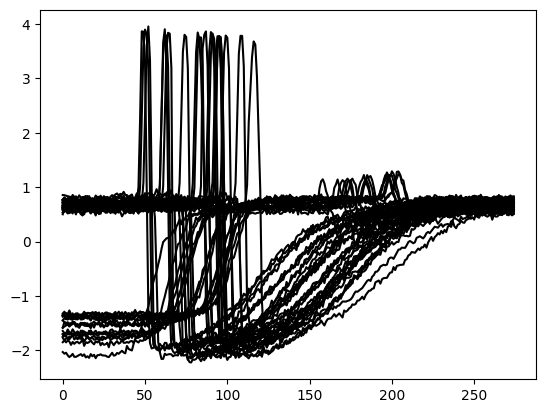

In [2]:
from tslearn.datasets import CachedDatasets

data_loader = CachedDatasets()
X_train, y_train, X_test, y_test = data_loader.load_dataset("Trace")

X_subset = X_train[y_train < 4]
np.random.shuffle(X_subset)
X_subset = X_subset[:50]

for ts in X_subset:
    plt.plot(ts[:, 0], color='k')

# $k$-means clustering

**Question #2.** Implement the Lloyd's algorithm for a $k$-means that would use soft-DTW as 
its base metric.
You can rely on ``tslearn`` functions (see imports above) for "distance" computations and barycenter
estimation.
Your function should return both the current assignments and the barycenters.
Check that it runs smoothly for a few iterations on `X_subset` (leave quantitative evaluation aside for now).

In [3]:
def kmeans_soft_dtw(X, gamma, k, max_iter=10):
    n_timeseries, n_timestamps, n_features = X.shape

    # Init barycenters at random
    barycenters = X[np.random.randint(n_timeseries, size=k)]

    for e in range(max_iter):
        # Assign a cluster to each time series
        assign = np.zeros((n_timeseries, ), dtype=int)
        for i in range(n_timeseries):
            dists = []
            for j in range(k):
                dists.append(soft_dtw(X[i], barycenters[j], gamma=gamma))
            assign[i] = np.argmin(dists)
        # Update centroids (barycenters) for each cluster
        for j in range(k):
            barycenters[j] = softdtw_barycenter(X[assign == j], gamma=gamma)
    
    return assign, barycenters

assign, centroids = kmeans_soft_dtw(X_subset, gamma=.1, k=3, max_iter=3)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


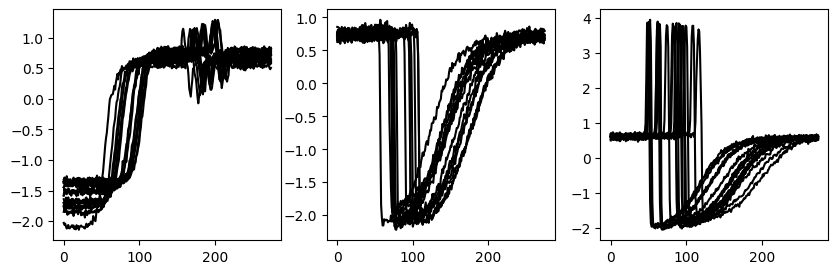

In [4]:
plt.figure(figsize=(10, 3))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    for ts in X_subset[assign == i]:
        plt.plot(ts[:, 0], 'k')

**Question #3.** Implement the Lloyd's algorithm for a $k$-means that would use **DTW** as 
its base metric.
You can rely on ``tslearn`` functions (see imports above) for "distance" computations and barycenter
estimation.
Your function should return both the current assignments and the barycenters.
Check that it runs smoothly for a few iteration on `X_subset` (leave quantitative evaluation aside for now).

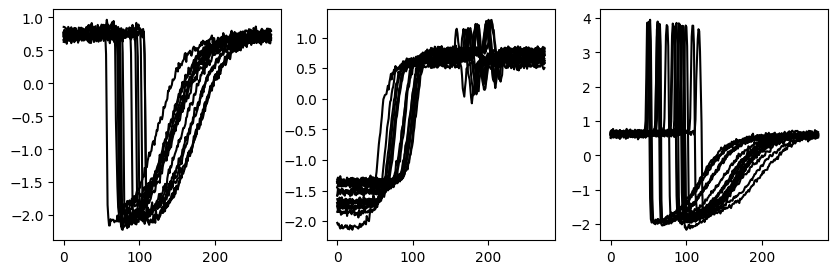

In [5]:
def kmeans_dtw(X, k, max_iter=10):
    n_timeseries, n_timestamps, n_features = X.shape

    # Init barycenters at random
    barycenters = X[np.random.randint(n_timeseries, size=k)]

    for e in range(max_iter):
        # Assign a cluster to each time series
        assign = np.zeros((n_timeseries, ), dtype=int)
        for i in range(n_timeseries):
            dists = []
            for j in range(k):
                dists.append(dtw(X[i], barycenters[j]))
            assign[i] = np.argmin(dists)
        # Update centroids (barycenters) for each cluster
        for j in range(k):
            barycenters[j] = dtw_barycenter_averaging(X[assign == j])
    
    return assign, barycenters

assign, centroids = kmeans_dtw(X_subset, k=3, max_iter=3)
plt.figure(figsize=(10, 3))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    for ts in X_subset[assign == i]:
        plt.plot(ts[:, 0], 'k')

**Question #4.** Implement a function that would assess the quality of a clustering in terms of 
intra-cluster inertia, computed using **DTW** as the base metric.
Your function should take a time series dataset, corresponding assignments and barycenters as inputs.

In [6]:
def dtw_cost(X, assign, barycenters):
    n_timeseries, n_timestamps, n_features = X.shape
    k = barycenters.shape[0]

    total_cost = 0.
    for j in range(k):
        for ts in X[assign == j]:
            total_cost += dtw(ts, barycenters[j]) ** 2
    
    return total_cost



**Question #5.** Compare your $k$-means implementations in terms of DTW inertia.
For a fair comparison, make sure that they are initialized similarly, by appropriately setting your
random number generator seeds.
What do you observe? Is that expected / Do you have an explanation for that?

In [7]:
np.random.seed(0)
assign, centroids = kmeans_dtw(X_subset, k=3, max_iter=3)
print("DTW kmeans:", dtw_cost(X_subset, assign, centroids))

np.random.seed(0)
assign, centroids = kmeans_soft_dtw(X_subset, k=3, gamma=.1, max_iter=3)
print("softDTW kmeans:", dtw_cost(X_subset, assign, centroids))

DTW kmeans: 246.81789807453515
softDTW kmeans: 262.21139582091155


# Multi-step ahead forecasting

In this section, your goal will be to implement a single-hidden-layer perceptron for time series forecasting.
Your network will be trained to minimize normalized soft-DTW[^1].

To do so, we will rely on a `torch`-compatible implementation of soft-DTW [available in `tslearn`](https://tslearn.readthedocs.io/en/stable/gen_modules/metrics/tslearn.metrics.SoftDTWLossPyTorch.html).

[^1]: Normalized soft-DTW (also coined soft-DTW divergence) between time series $\mathbf{x}$ and 
$\mathbf{x}^\prime$ is defined as: 
$$\text{soft-DTW}(\mathbf{x}, \mathbf{x}^\prime) - \frac{1}{2} \left( \text{soft-DTW}(\mathbf{x}, \mathbf{x}) + \text{soft-DTW}(\mathbf{x}^\prime, \mathbf{x}^\prime) \right)$$


**Question #6.** Define an MLP model that would allow training
a single-hidden-layer model using normalized soft-DTW as a criterion to be optimized.
Train your network for 200 epochs on a forecasting task that would consist, given the first 150 elements
of a time series, in predicting the next 125 ones. You can use the training loop provided below:

In [8]:
import torch
from torch.utils.data import DataLoader, TensorDataset

def train_model(model, X, y, epochs, criterion, optimizer):
    dataset = TensorDataset(torch.tensor(X).float(), torch.tensor(y).float())
    dataloader = DataLoader(dataset, batch_size=10, shuffle=True)
    for epoch in range(epochs):
        for inputs, targets in dataloader:
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets).mean()

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

In [9]:
from torch import nn
from torch import optim

from tslearn.metrics import SoftDTWLossPyTorch

class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        x = x.squeeze()
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x.unsqueeze(dim=-1)
    
model = SimpleMLP(150, 256, 125)
train_model(model, X_subset[:, :150], X_subset[:, 150:], 
            epochs=200, criterion=SoftDTWLossPyTorch(gamma=.1, normalize=True), 
            optimizer=optim.Adam(model.parameters(), lr=0.01))

Epoch [1/200], Loss: 28.7442
Epoch [2/200], Loss: 24.2526
Epoch [3/200], Loss: 5.2182
Epoch [4/200], Loss: 3.8011
Epoch [5/200], Loss: 4.9263
Epoch [6/200], Loss: 2.5580
Epoch [7/200], Loss: 1.4611
Epoch [8/200], Loss: 1.9946
Epoch [9/200], Loss: 2.7000
Epoch [10/200], Loss: 0.7887
Epoch [11/200], Loss: 1.5995
Epoch [12/200], Loss: 0.8237
Epoch [13/200], Loss: 0.7191
Epoch [14/200], Loss: 0.3562
Epoch [15/200], Loss: 0.3876
Epoch [16/200], Loss: 1.3687
Epoch [17/200], Loss: 0.8373
Epoch [18/200], Loss: 4.1366
Epoch [19/200], Loss: 2.0929
Epoch [20/200], Loss: 3.9773
Epoch [21/200], Loss: 0.5258
Epoch [22/200], Loss: 0.6074
Epoch [23/200], Loss: 0.6011
Epoch [24/200], Loss: 0.4947
Epoch [25/200], Loss: 0.7056
Epoch [26/200], Loss: 0.3302
Epoch [27/200], Loss: 0.1977
Epoch [28/200], Loss: 0.1609
Epoch [29/200], Loss: 0.1394
Epoch [30/200], Loss: 0.2449
Epoch [31/200], Loss: 0.3537
Epoch [32/200], Loss: 0.1560
Epoch [33/200], Loss: 0.3254
Epoch [34/200], Loss: 0.1461
Epoch [35/200], Loss:

**Question #7.** Use the following code block to qualitatively assess quality of your 
network's predictions.
Do not hesitate to change the time series index to visualize the result for different time series.

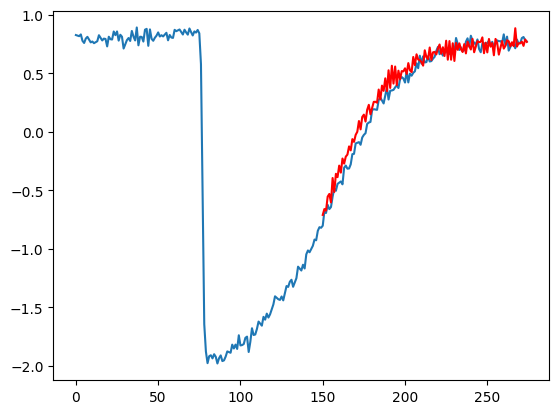

In [10]:
import matplotlib.pyplot as plt

ts_index = 50

y_pred = model(torch.tensor(X_test[:, :150]).float()).detach().numpy()

plt.figure()
plt.plot(X_test[ts_index].ravel())
plt.plot(np.arange(150, 275), y_pred[ts_index], 'r-')
plt.show()